In [1]:
from audiointerp.dataset.esc50 import ESC50dataset
from audiointerp.model.cnn14 import TransferCnn14
from audiointerp.fit import Trainer, plot_learning_curves
from audiointerp.processing.spectrogram import LogSTFTSpectrogram, plot_spec
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as T_audio
import torch

In [2]:
root_dir = "/root/ESC50"
# root_dir = "/home/yuliya/ESC50"
sr = 32000
train_folds = [1, 2, 3]
valid_folds = [4]
test_folds = [5]

In [3]:
n_fft = 1024
hop_length = 320
win_length = 1024
top_db = None

In [4]:
feature_extractor = LogSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, top_db=top_db,
    return_phase=False, return_full_db=False
)

In [5]:
feature_augs = nn.Sequential(
    T_audio.FrequencyMasking(20),
    T_audio.TimeMasking(20)
)

In [6]:
train_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=train_folds, normalize="peak", feature_extractor=feature_extractor, feature_augs=feature_augs)
valid_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=valid_folds, normalize="peak", feature_extractor=feature_extractor)
test_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak", feature_extractor=feature_extractor)

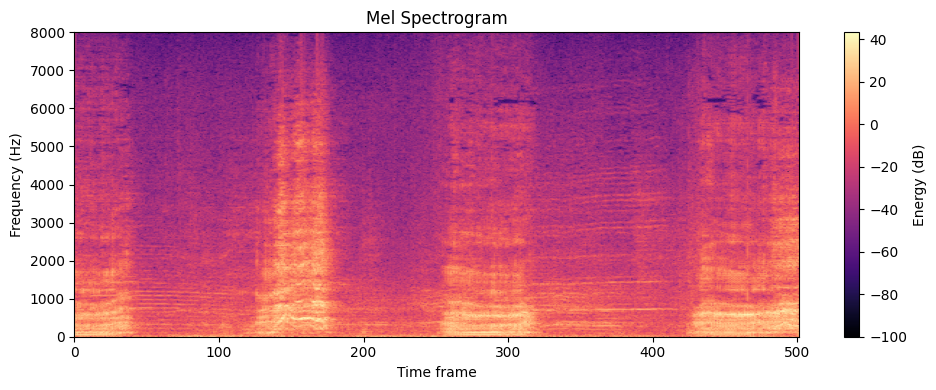

In [9]:
plot_spec(test_data[0][0], sample_rate=sr)

In [10]:
train_loader_kwargs = {"batch_size": 32, "shuffle": True}
valid_loader_kwargs = {"batch_size": 32, "shuffle": False}
test_loader_kwargs = {"batch_size": 32, "shuffle": False}

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1")
model_cls = TransferCnn14
model_kwargs = {"num_classes": 50, "num_bins": 513}
model_pretrain_weights_path = "weights/Cnn14_mAP=0.431.pth"

optimizer_cls = optim.Adam
optimizer_kwargs = {"lr": 1e-4}

criterion_cls = nn.CrossEntropyLoss
use_mixup = True
mixup_alpha = 0.2

In [13]:
model_trainer = Trainer(
    model_cls=model_cls,
    train_data=train_data,
    train_loader_kwargs=train_loader_kwargs,
    criterion_cls=criterion_cls,
    optimizer_cls=optimizer_cls,
    model_kwargs=model_kwargs,
    model_pretrain_weights_path=model_pretrain_weights_path,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
    valid_data=valid_data,
    valid_loader_kwargs=valid_loader_kwargs,
    test_data=test_data,
    test_loader_kwargs=test_loader_kwargs,
    use_mixup=use_mixup,
    mixup_alpha=mixup_alpha
)

Random seed set to: 42


In [14]:
train_losses, train_accs, val_losses, val_accs, test_loss, test_acc = model_trainer.train(num_epochs=2, save_weights_path="lo_cnn.pth")

Epoch:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 1/2 [01:13<01:13, 73.25s/it]

Train Loss: 3.9098, Train Acc: 0.0245
Valid Loss: 3.8248, Valid Acc: 0.0750


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:26<00:00, 73.25s/it]


Train Loss: 3.7186, Train Acc: 0.0745
Valid Loss: 3.3802, Valid Acc: 0.1925
Best val Acc: 0.1925
Модель сохранена в lo_cnn.pth
Test Loss: 3.3750, Test Acc: 0.2050


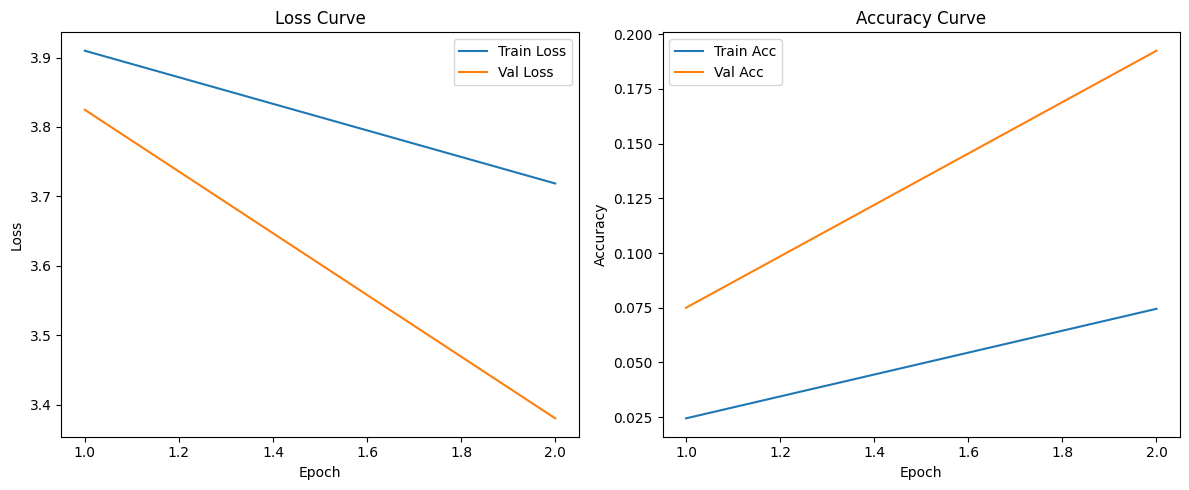

In [15]:
plot_learning_curves(train_losses=train_losses, train_accs=train_accs, val_losses=val_losses, val_accs=val_accs)